In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import confusion_matrix
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

cpu


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomHorizontalFlip(p=0.5)
    ])

batch_size = 4
epochs = 20

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.25)
        
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(64 * 3 * 3, 64)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

import torch.optim as optim
net = Net()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)



In [4]:
y_loss = {}  # loss history
y_loss['train'] = []
y_loss['val'] = []
y_acc = {}  # loss history
y_acc['train'] = []
y_acc['val'] = []
x_epoch = []



In [5]:
total = 0 
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    total_loss = 0.0
    count = 0 
    correct_pred = 0 
    correct_pred_val = 0 
    total_pred = 0 
    total_pred_val = 0 
    
    for i, data in enumerate(trainloader, 0):
        
        count += 1
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device) , data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred += 1
            total_pred += 1
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    

        curloss = loss.item()
        running_loss += curloss
        total_loss += curloss
        if i % 2000 == 1999:    # print every 2000 mini-batches
            total += 1 
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            
            
            with torch.no_grad():
                correct = 0
                loss_val = 0.0
                countval = 0
                for data_val in testloader:
                    countval += 1
                    inputs_val, labels_val = data_val[0].to(device) , data_val[1].to(device)
                    # calculate outputs by running images through the network
                    outputs_val = net(inputs_val)
                    
                    # the class with the highest energy is what we choose as prediction
                    _, predicted = torch.max(outputs_val.data, 1)
                    for label, prediction in zip(labels_val, predicted):
                        if label == prediction:
                            correct_pred_val += 1
                        total_pred_val += 1
                    loss = criterion(outputs, labels)
                    loss_val += loss.item()
                    if countval == 2000:
                        break
            loss_val /= countval
            y_loss['val'].append(loss_val)
            y_loss['train'].append(total_loss/count)
            y_acc['train'].append(correct_pred / total_pred )
            y_acc['val'].append(correct_pred_val/total_pred_val)
            
    x_epoch.append(total)
    # since we're not training, we don't need to calculate the gradients for our outputs
    
    
print('Finished Training')

[1,  2000] loss: 2.248
[1,  4000] loss: 2.182
[1,  6000] loss: 2.152
[1,  8000] loss: 2.131
[1, 10000] loss: 2.121
[1, 12000] loss: 2.115
[2,  2000] loss: 2.094
[2,  4000] loss: 2.094
[2,  6000] loss: 2.090
[2,  8000] loss: 2.087
[2, 10000] loss: 2.079
[2, 12000] loss: 2.061
[3,  2000] loss: 2.058
[3,  4000] loss: 2.054
[3,  6000] loss: 2.036
[3,  8000] loss: 2.044
[3, 10000] loss: 2.040
[3, 12000] loss: 2.046
[4,  2000] loss: 2.039
[4,  4000] loss: 2.024
[4,  6000] loss: 2.024
[4,  8000] loss: 2.017
[4, 10000] loss: 2.019
[4, 12000] loss: 2.025
[5,  2000] loss: 2.012
[5,  4000] loss: 2.013
[5,  6000] loss: 2.010
[5,  8000] loss: 1.999
[5, 10000] loss: 2.011
[5, 12000] loss: 2.001
[6,  2000] loss: 2.001
[6,  4000] loss: 2.000
[6,  6000] loss: 1.998
[6,  8000] loss: 1.990
[6, 10000] loss: 1.990
[6, 12000] loss: 1.990
[7,  2000] loss: 1.983
[7,  4000] loss: 1.981
[7,  6000] loss: 1.986
[7,  8000] loss: 1.987
[7, 10000] loss: 1.980
[7, 12000] loss: 1.982
[8,  2000] loss: 1.977
[8,  4000] 

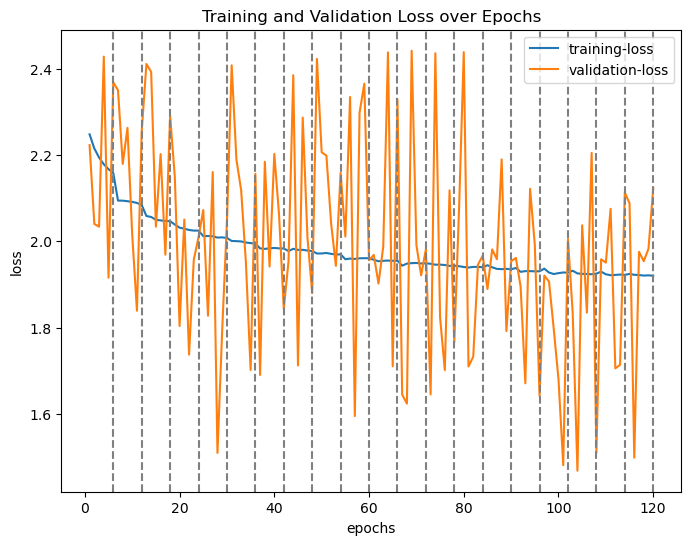

In [6]:
import matplotlib.pyplot as plt

# Define your data
x = [i for i in range(1,total+1)]

# Set the figure size
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the data on the axis
ax.plot(x, y_loss['train'] , label='training-loss')
ax.plot(x, y_loss['val'] , label='validation-loss')

for i in x_epoch:
    ax.axvline(i, color='gray', linestyle='--')

ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_title('Training and Validation Loss over Epochs')

# Show the graph
plt.show()


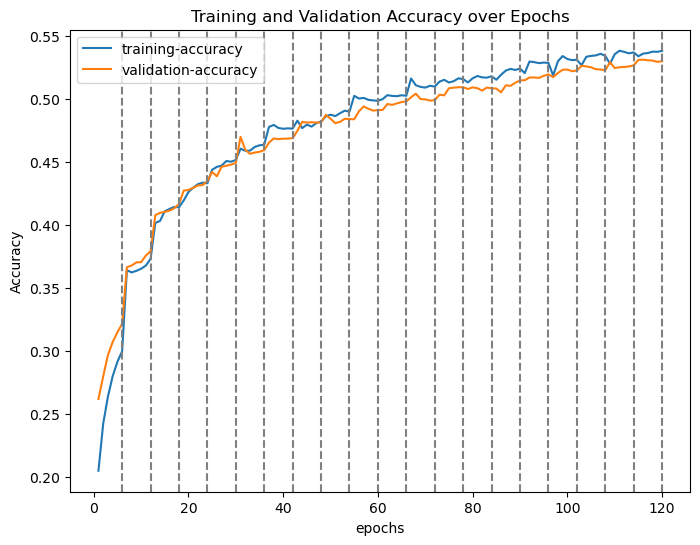

In [7]:
import matplotlib.pyplot as plt

# Define your data
x = [i for i in range(1,total+1)]


# Set the figure size
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the data on the axis
ax.plot(x, y_acc['train'] , label='training-accuracy')
ax.plot(x, y_acc['val'] , label='validation-accuracy')

for i in x_epoch:
    ax.axvline(i, color='gray', linestyle='--')

ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracy over Epochs')
# Show the graph
plt.show()


In [8]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data_check in testloader:
        inputs_val, labels_val = data_check[0].to(device) , data_check[1].to(device)
        
        outputs = net(inputs_val)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels_val, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 55.9 %
Accuracy for class: car   is 68.3 %
Accuracy for class: bird  is 37.4 %
Accuracy for class: cat   is 30.8 %
Accuracy for class: deer  is 43.7 %
Accuracy for class: dog   is 41.9 %
Accuracy for class: frog  is 57.6 %
Accuracy for class: horse is 60.2 %
Accuracy for class: ship  is 67.4 %
Accuracy for class: truck is 61.9 %


citation : https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html (mentioned in the assignment)